# Assignment 1: Hydraulic flow over a weir

Here we will examine many aspects of flow over a weir.  You will need a python environment that has numpy, scipy, matplotlib, ipympl, tqdm, netcdf4 and xarray installed.  

As of 15 Jan this is preliminary.  The last question (Q4) in particular is subject to change.  

For hints on using xarray and netCDF files, please see https://jklymak.github.io/Eos431Phy441/computing/analyze_veros.html#netcdf-and-xarray, and feel free to ask questions.  However, it is almost alwats the same as using numpy, just data sets are stored as one structure.


In [323]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib ipympl

from sve_hybrid import run_modelFVM

## Q1: setup:

Run the model as below.  Note that it will take a while, depending on the speed of your machine.  

This model solves the shallow-water equations in 1-D.  There is a 25-m long channel, with a 0.2-m high, 1.6-m half-width Gaussian bump at $x=10\ \mathrm{m}$ (`zb` below.).  The channel is a constanty 1-m wide (`b`).  The flow starts of with 0 velocity transport (`Q = np.zeros(nx)`).  The left (upstream) side of the channel starts with a height of $0.13\ \mathrm{m}$, and the right (downstream) side with a height of $0.33\ \mathrm{m}$.  

The boundary condition on the right side is that the resevoir depth cannot change (eg, $h(x=25) = 0.33$, but the flow rate can be whatever we want.).  On the left side ($x=0\ \mathrm{m}$), the depth can be any value, but the flow rate is always a constant $Q_{up} = 0.18\ \mathrm{m^3\,s^{-1}}$.  The model has a harmonic diffusion of both $Q$, the flow rate,  and $A$ the cross sectional area of the flow.  

The model returns a matrix of $A(t, x)$ and $Q(t,x)$, saved every `saveT` timesteps, with each row representing a time step.  So `A[10,:]` is $A(t=10^4\,\delta t, x)$ the 10th saved timestep.  

Note because the simulation takes a while, it is a good idea to save the data, and then only run the model again if you need to. I strongly prefer `xarray` for saving data like this, as the data is all in one file, and has dimensions attached for clarity.

0.18


Running model:   5%|▌         | 784/15000 [00:00<00:01, 7832.63it/s]

upstream subcritical
upstream subcritical


Running model: 100%|██████████| 15000/15000 [00:01<00:00, 9034.93it/s]


<xarray.Dataset> Size: 611kB
Dimensions:  (x: 250, time: 151)
Coordinates:
  * x        (x) float64 2kB 0.0 0.1 0.2 0.3 0.4 ... 24.5 24.6 24.7 24.8 24.9
  * time     (time) float64 1kB 0.0 1.0 2.0 3.0 4.0 ... 147.0 148.0 149.0 150.0
Data variables:
    A        (time, x) float64 302kB 0.13 0.13 0.13 0.13 ... 0.0 0.0 0.0 0.0
    Q        (time, x) float64 302kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zb       (x) float64 2kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    b        (x) float64 2kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    Qup      float64 8B 0.18
    Adown    float64 8B 0.33
Attributes:
    description:  Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, ...

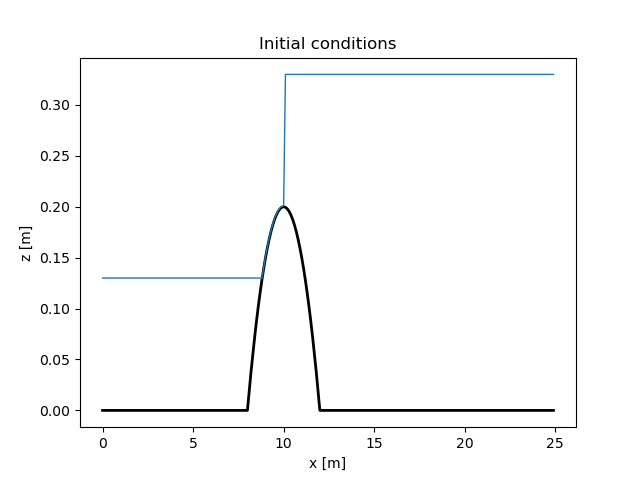

In [337]:
# Case 3 transcritical bump
nTimes = 15_000
saveT = 100
dt = 0.01
time = np.arange(0, dt*nTimes+1, saveT*dt)

dx = 0.1   # m 
nx = 250 
x = np.arange(0, dx*nx, dx)
#x = x
# width:
b = np.ones(nx)  # width in m.

Manning = 0.0014 + 0*b # friction
Manning = 0.0 * Manning
# Manning[:30] = 0
drylim = 1e-10

# Bottom
zb = np.zeros(nx)
zb[(x>=8.0) & (x<=12)] = 0.2 - 0.05*(x[(x>=8.0) & (x<=12)]-10)**2
#zb = 0.2*np.exp(-((x-10)/1.6)**2)

# initial height
h = 0.13 - zb
h[x>10] = 0.33 - zb[x>10]
A = h * b
drylim=1e-3

# inital flow
Qup = 0.18
u0 = Qup / A[0]
print(Qup)

Q = np.zeros(nx) + 0* u0*A # Flow rate m^3/s
#Q = np.zeros(nx) + Qup # Flow rate m^3/s

Q[(A/b)<drylim] = 0.0
A[(A/b)<drylim]= drylim * b[(A/b)<drylim]


if True:
    saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
                         kappa=0*3e-1/16, 
                         K4=10e-5, Manning=Manning, drylim=drylim, Adown=A[-1])
    #saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
    #                            kappa=.5e-1/16, Manning=0.0 * b, drylim=drylim, Adown=A[-1])

    # Save the model output to a netcdf file.  
    ds = xr.Dataset(coords={'x':x, 'time':time})
    ds.attrs['description'] = 'Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, kappa=0, A4=1e-4, Manning=0.0 * b, drylim=drylim, Adown=A[-1])'
    ds['x'].attrs['description'] = 'x [m]'
    ds['time'].attrs['description'] = 'time [s]'
    ds['A'] = (('time', 'x'), saveA)
    ds['A'].attrs['description'] =  'Cross-sectional area [m^2]'
    
    ds['Q'] = (('time', 'x'), saveQ)
    ds['Q'].attrs['description'] =  'Flow rate [m^3/s]'
    
    ds['zb'] = (('x'), zb)
    ds['zb'].attrs['description'] =  'topography [m]'
    ds['b'] = (('x'), b)
    ds['b'].attrs['description'] =  'channel width [m]'
    ds['Qup'] = ((), Qup)
    ds['Qup'].attrs['description'] =  'upstream forcing [m^3/s]'
    ds['Adown'] = ((), A[-1])
    ds['Adown'].attrs['description'] =  'downstream reservoir cross section [m^2]'
    ds.to_netcdf('ModelRunAssign01_01B.nc')
else: 
    ds = xr.open_dataset('ModelRunAssign01_01B.nc')
fig, ax = plt.subplots()
ax.plot(ds.x, ds.zb, linewidth=2, color='k')
ax.plot(ds.x, ds.zb+ds.sel(time=0).A, linewidth=1, color='C0')
ax.set(xlabel='x [m]', ylabel='z [m]', title='Initial conditions')
display(ds)

### Q1.1 Plot

Plot the raw data versus x.  I like plotting all of it, and then highlighting the initial and final conditions with a thicker line.  Note that while the model returns $A$ you probably want to plot $z+h$, the height of the free surface.  However, I usually prefer plotting $Q$ rather than $u$.

Please label your plots!

In [ ]:
# Code/plotting answer here (use more cells if desired)

### Q1.2 Hovmoller diagram

It is also often useful in fluid mechanics to plot a Hovmoller diagram.  this is your quantity of interest colored by value, versus $x$ and $t$ (eg use `pcolormesh`)

In [ ]:
# Code/plotting answer here (use more cells if desired)

### Q1.3 Describe

Very briefly describe the stages of simulation, perhaps extract a few time slices to make your point. 

Note `dd = ds.sel(time=10, method='nearest')` will return a new dataset `dd` that only has one time in it, at the closest time to 10 s that exists in `ds`

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

## Q2: Compare with theory

Lets consider the last good simulation step and see if our steady theory works.

### Q2.1 does solution conserve mass?

How well does the solution conserve mass? Rember that any transport convergence must show up as vertical change in the surface height.

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

### Q2.1 plot Froude number

Compute the value of the Froude number as a function of x, and describe how it conforms (or not) to our expectations.

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

### Q2.3 Compare flow crosssection with theory

Given $q=0.18\ \mathrm{m^2\,s^{-1}}$ and $h(x)$ we can calculate the flow everywhere upstream of the hydraulic jump.  See how well the flow does comapred to the theoretical prediction.  Note there is a root finding exercise here, and there are multiple roots at each value of $h(x)$

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

### Q2.4 Check Bernoulli function is constant

Show that the Bernoulli function at the surface ($z=h+d$) is approximately constant and comment on where it is not.  Also argue that the Bernoulli function has the same value at $z=h(x)$

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

### Q2.5 Check that energy is conserved

Consider the terms of the vertically integrated energy budget, and show where they balance and discuss where they do not.  Be sure to show how you derived the terms, and note the units and how they relate to Joules or Watts.  What is the rate that energy is being lost in the hydraulic jump?  How much energy is lost total in the system:

*Text/markdown answer here.*  (use more cells if desired)

In [ ]:
# Code/plotting answer here (use more cells if desired)

The total energy transport plus the pressure work is approximately constant until the hydraulic jump after which it drops.  We see the expected exchange between KE and PE, with KE increasing over the bump, initially at the expense of pressure work (note the PE increases over the bump until the obstacle crest), and then at the expense of the potential energy and pressure work.  

The hydraulic jump loses energy in the drop from 750 W/m to 621 W/m = 129 W/m.  

Total energy loss is approximately 138 W/m, though we should check for energy rate of change as well!


### Q2.6 Figure out the jump location

There is clearly a hydraulic jump on the topography.  We can figure out its location by noting that the Bernoulli function is known in the downstream reservoir, in addition to knowing it on the ridge crest.  These Bernoulli functions are constant to the left and right side of the jump, so that gives two equations in three unknowns, $d_{left}$, $d_{right}$, $h(x_j) = h_j$.   A third equation can be derived by conserving the flux of momentum across the hydraulic jump. 

These three equations are pretty non-linear, so I solved using `scipy.optimize.root`, with the three unknowns as the roots. 

Plot the upstream and downstream solutions for d on the same plot, and indicate the location of the hydraulic jump.  


In [333]:
import scipy.optimize as optim

# Downstream Bernoulli
A = 0.5 *Qup**2 / dd.A[-10]**2 + g * dd.A[-10]
dc = dd.sel(x=10, method='nearest').A
hm = np.max(dd.zb)

# Upstream Bernoulli
B = 0.5 *Qup**2 / dc**2 + g * (dc + hm)


def fun(x, *args):
    dm = x[0]
    dp = x[1]
    hj = x[2]
    if dp < dm:
        res = [1e6, 1e6, 1e6]
    elif dp < 0:
        res = [1e6, 1e6, 1e6]
    elif dm < 0:
        res = [1e6, 1e6, 1e6]
    elif hj < 0:
        res = [1e6, 1e6, 1e6]        
    else: 
        res = [Qup**2 / dm**2 - g * dp / 2  *(1 +dp/dm),
                (0.5*Qup**2 / dp**2 + g * (dp+hj)  - A).values ,
                (0.5*Qup**2 / dm**2 + g * (dm+hj)  - B).values 
              ]
    return res

# initial guess
dp = dd.A[-10] 
dm = dc / 18
hj = 0.0
result = optim.root(fun, x0=np.array([dm, dp, hj]), options={'maxiter':10_000, 'xtol':1e-10})
print(result)

 message: The solution converged.
 success: True
  status: 1
     fun: [-3.014e-12  1.041e-12  8.882e-16]
       x: [ 7.594e-02  2.594e-01  6.111e-02]
  method: hybr
    nfev: 30
    fjac: [[-9.286e-01  1.564e-01 -3.365e-01]
           [ 3.491e-01  6.086e-02 -9.351e-01]
           [ 1.257e-01  9.858e-01  1.111e-01]]
       r: [ 1.907e+02  2.313e+01 -1.767e+00 -8.325e+00 -8.576e+00
            1.076e+01]
     qtf: [ 1.006e-09 -3.260e-10  2.095e-10]


/var/folders/kx/4c3bx_w92t31pqyvg6ws03200000gn/T/ipykernel_9739/1608275135.py:35: OptimizeWarning: Unknown solver options: maxiter
  result = optim.root(fun, x0=np.array([dm, dp, hj]), options={'maxiter':10_000, 'xtol':1e-10})


In [ ]:
# Code/plotting answer here (use more cells if desired)

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

## Q3 Run your own version

Run your own version of the simulation, and discuss the results.  There is no need to do all the analyses above, but you might discuss how it gets to the steady state, comment if the flow is sub/super critical and where. 

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)

## Q4 Dam break problem and characteristics

Run the following code, and plot a Hovmoller diagram.  

Compare the results to the results using the method of characteristics.  

0.0


Running model:  35%|███▍      | 1039/3000 [00:00<00:00, 5209.10it/s]

upstream subcritical
upstream subcritical


Running model: 100%|██████████| 3000/3000 [00:00<00:00, 5423.75it/s]


<xarray.Dataset> Size: 520kB
Dimensions:  (x: 1000, time: 31)
Coordinates:
  * x        (x) float64 8kB 0.0 0.025 0.05 0.075 0.1 ... 24.9 24.93 24.95 24.98
  * time     (time) float64 248B 0.0 0.25 0.5 0.75 1.0 ... 6.5 6.75 7.0 7.25 7.5
Data variables:
    A        (time, x) float64 248kB 0.33 0.33 0.33 0.33 ... 0.0 0.0 0.0 0.0
    Q        (time, x) float64 248kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    zb       (x) float64 8kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    b        (x) float64 8kB 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    Qup      float64 8B 0.0
    Adown    float64 8B 0.23
Attributes:
    description:  Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, ...

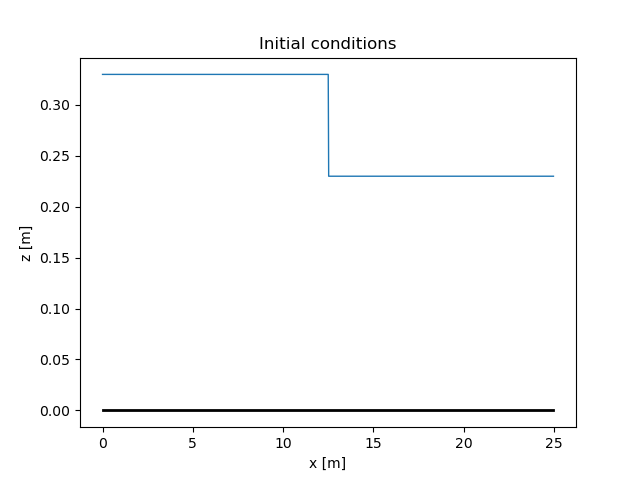

In [338]:
# Case 3 transcritical bump
nTimes = 3_000
saveT = 100
dt = 0.01 / 4
time = np.arange(0, dt*(nTimes+100), saveT*dt)

dx = 0.1 / 4  # m 
nx = 250 * 4
x = np.arange(0, dx*nx, dx)
#x = x
# width:
b = np.ones(nx)  # width in m.

Manning = 0.0014 + 0*b # friction
Manning = 0.0 * Manning
# Manning[:30] = 0
drylim = 1e-10

# Bottom
zb = np.zeros(nx)
#zb[(x>=8.0) & (x<=12)] = 0.2 - 0.05*(x[(x>=8.0) & (x<=12)]-10)**2
#zb = 0.2*np.exp(-((x-10)/1.6)**2)

# initial height
h = 0.33 - zb
h[x>12.5] = 0.23 - zb[x>12.5]
A = h * b
drylim=1e-3

# inital flow
Qup = 0.0
u0 = Qup / A[0]
print(Qup)

Q = np.zeros(nx) + 0* u0*A # Flow rate m^3/s
#Q = np.zeros(nx) + Qup # Flow rate m^3/s

Q[(A/b)<drylim] = 0.0
A[(A/b)<drylim]= drylim * b[(A/b)<drylim]


if True:
    saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
                         kappa=0*3e-1/16, 
                         K4=20e-5/2**4, Manning=Manning, drylim=drylim, Adown=A[-1])
    #saveA, saveQ = run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, 
    #                            kappa=.5e-1/16, Manning=0.0 * b, drylim=drylim, Adown=A[-1])
    time = time[:(len(saveA[:, 0])+1)]
    # Save the model output to a netcdf file.  
    ds = xr.Dataset(coords={'x':x, 'time':time})
    ds.attrs['description'] = 'Made with run_modelFVM(nTimes, saveT, dt, dx, zb, b, A, Q, Qup=Qup, Aup=None, kappa=0, A4=1e-4, Manning=0.0 * b, drylim=drylim, Adown=A[-1])'
    ds['x'].attrs['description'] = 'x [m]'
    ds['time'].attrs['description'] = 'time [s]'
    ds['A'] = (('time', 'x'), saveA)
    ds['A'].attrs['description'] =  'Cross-sectional area [m^2]'
    
    ds['Q'] = (('time', 'x'), saveQ)
    ds['Q'].attrs['description'] =  'Flow rate [m^3/s]'
    
    ds['zb'] = (('x'), zb)
    ds['zb'].attrs['description'] =  'topography [m]'
    ds['b'] = (('x'), b)
    ds['b'].attrs['description'] =  'channel width [m]'
    ds['Qup'] = ((), Qup)
    ds['Qup'].attrs['description'] =  'upstream forcing [m^3/s]'
    ds['Adown'] = ((), A[-1])
    ds['Adown'].attrs['description'] =  'downstream reservoir cross section [m^2]'
    ds.to_netcdf('ModelRunAssign01_02B.nc')
else: 
    ds = xr.open_dataset('ModelRunAssign01_02B.nc')

fig, ax = plt.subplots()
ax.plot(ds.x, ds.zb, linewidth=2, color='k')
ax.plot(ds.x, ds.zb+ds.sel(time=0).A, linewidth=1, color='C0')
ax.set(xlabel='x [m]', ylabel='z [m]', title='Initial conditions')

display(ds)

In [ ]:
# Code/plotting answer here (use more cells if desired)

In [ ]:
# Code/plotting answer here (use more cells if desired)

*Text/markdown answer here.*  (use more cells if desired)